## Load documents with IDs

In [13]:
import requests 

base_url = 'https://github.com/tejasjbansal/LLM-Zoomcamp/blob/main'
relative_url = '3.%20Vector%20databases%20and%20retrieval%20techniques/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [14]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [15]:
import pandas as pd

base_url = 'https://github.com/tejasjbansal/LLM-Zoomcamp/blob/main'
relative_url = '3.%20Vector%20databases%20and%20retrieval%20techniques/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [16]:
len(ground_truth)

1830

In [17]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [18]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [19]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

## Index data

In [11]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [21]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [22]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:58<00:00, 16.11it/s]


## Retrieval

In [23]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [24]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

In [25]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [29]:
import os
from groq import Groq
from dotenv import load_dotenv

# client = OpenAI()

# def llm(prompt, model='gpt-4o'):
#     response = client.chat.completions.create(
#         model=model,
#         messages=[{"role": "user", "content": prompt}]
#     )
    
#     return response.choices[0].message.content


def llm(prompt,model):
    # load environment variables
    load_dotenv()
    
    # create client calling Groq class
    client = Groq(api_key=os.getenv('GROQ_API_KEY'))
    
    # create a query
    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
    )
    
    # print the response
    return response.choices[0].message.content

In [30]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama3-8b-8192') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt,model)
    return answer

In [31]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [32]:
rag(ground_truth[10])

'Based on the CONTEXT, I can answer the QUESTION:\n\nAre sessions recorded if I miss one?\n\nAnswer: Yes, all sessions are recorded. According to the context, "Everything is recorded, so you won’t miss anything." Additionally, the FAQ states that the office hours, which are live sessions, are also recorded.'

In [33]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [37]:
answer_orig = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'
answer_llm = 'Based on the CONTEXT, I can answer the QUESTION:\n\nAre sessions recorded if I miss one?\n\nAnswer: Yes, all sessions are recorded. According to the context, "Everything is recorded, so you won’t miss anything." Additionally, the FAQ states that the office hours, which are live sessions, are also recorded.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.5839616

In [38]:
answers = {}

In [ ]:
# Below function require almost 2 hrs to execute and required money to execute LLM model so we use the file which course shared

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': aanswer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [43]:
answers[0]

{'answer_llm': 'According to the FAQ database, you can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials. Additionally, you can also use the link http://mlzoomcamp.com/#syllabus to access the course syllabus.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [1]:
import pandas as pd

df_gpt4o = pd.read_csv("data/results-gpt4o.csv")

In [2]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


## Evaluating GPT 3.5

In [57]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [60]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
# Below function require almost 2 hrs to execute and required money to execute LLM model so we use the file which course shared

results_gpt35 = map_progress(pool, ground_truth, process_record)

In [3]:
df_gpt35  = pd.read_csv("data/results-gpt35.csv")

In [4]:
df_gpt35 .head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by going to the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I am sorry, but there is no direct link provid...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the course does not have a GitHub reposito...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,Based on the information provided in the FAQ d...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


## Cosine similarity
A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [5]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [6]:
record = results_gpt4o[0]

In [7]:
record

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [8]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [12]:
from tqdm.auto import tqdm

similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [01:45<00:00, 17.34it/s]


In [13]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

### gpt-3.5-turbo

In [14]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [01:23<00:00, 21.98it/s]


In [15]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [16]:
import matplotlib.pyplot as plt

### gpt-4o-mini

In [102]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [81]:
results_gpt4omini = []

In [ ]:
# Below function require almost 2 hrs to execute and required money to execute LLM model so we use the file which course shared


for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

In [17]:
df_gpt4o_mini = pd.read_csv('data/results-gpt4o-mini.csv')
results_gpt4omini = df_gpt4o_mini.to_dict(orient='records')

In [18]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [01:33<00:00, 19.66it/s]


In [19]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

/tmp/ipykernel_2783/875947043.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')
/tmp/ipykernel_2783/875947043.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_2783/875947043.py:5: UserWarning: 

`distplot` is a 

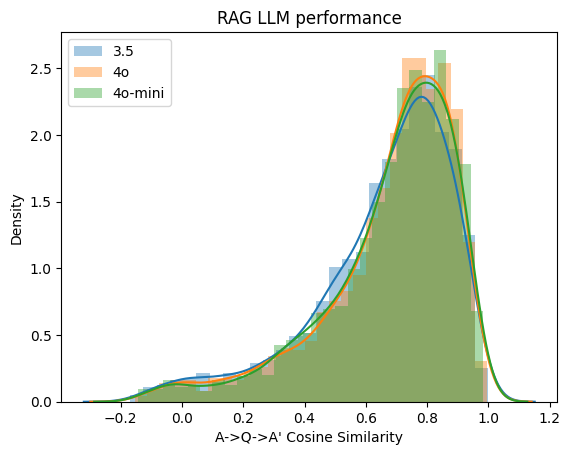

In [20]:
import seaborn as sns

sns.distplot(df_gpt35['cosine'], label='3.5')
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [21]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [22]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [23]:
samples = df_sample.to_dict(orient='records')

In [24]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [25]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [30]:
answer = llm(prompt, model='llama3-8b-8192')

In [37]:
answer

'Here is the evaluation:\n\n{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides a clear and exact syntax for using `precision_recall_fscore_support` in Python, which matches the original answer. The code snippet is identical, making it highly relevant and accurate."\n}'

In [32]:
import json

evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:47<00:00,  2.32s/it]


In [ ]:
# Dd not have Openai credits so didn't execute below cell use the LLM Judge output file instead.

json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [70]:
df_evaluations = pd.read_csv('data/evaluations-aqa.csv')
df_evaluations_2 = pd.read_csv('data/evaluations-qa.csv')

In [71]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           124
PARTLY_RELEVANT     16
NON_RELEVANT        10
Name: count, dtype: int64

In [72]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           129
PARTLY_RELEVANT     18
NON_RELEVANT         3
Name: count, dtype: int64

In [73]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer does not address the spec...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The generated answer provides information abou...
87,NON_RELEVANT,The generated answer does not address the orig...
90,NON_RELEVANT,The generated answer responds to a question ab...
93,NON_RELEVANT,The generated answer does not address the topi...
116,NON_RELEVANT,The generated answer discusses the recommended...
138,NON_RELEVANT,The generated answer addresses a different iss...
139,NON_RELEVANT,The generated answer does not relate to the to...


In [74]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer does not address the ques...
49,NON_RELEVANT,The generated answer explicitly states that th...
139,NON_RELEVANT,The generated answer provides information abou...


## Saving all the data

In [75]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)